<a href="https://colab.research.google.com/github/Friba-Hussa1/FCNN_IMDB_dataset/blob/main/FCNN_IMDB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

### Exploring dataset

In [5]:
data=pd.read_csv('IMDB Dataset.csv', engine='python')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
print(data['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Pre-processing the Text

Lowercase

Remove HTML tags

Remove punctuation and numbers

Remove stopwords (optional)

In [7]:
import re
from bs4 import BeautifulSoup

def preprocess_text(text):

    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['cleaned_review']= data['review'].apply(preprocess_text)

### Encode Labels and Tokenize Text

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encode sentiment to 0/1
le = LabelEncoder()
data['label'] = le.fit_transform(data['sentiment'])  # pos -> 1, neg -> 0

# Tokenize
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_review'])
sequences = tokenizer.texts_to_sequences(data['cleaned_review'])

###Pad sequences

In [9]:
maxlen = 200
X = pad_sequences(sequences, maxlen=maxlen)
y = data['label'].values

### Load GloVe Embeddings

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-07-31 15:22:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-31 15:22:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-31 15:22:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
import numpy as np

embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f'Found {len(embedding_index)} word vectors.')

Found 400000 word vectors.


### Create Embedding Matrix

In [12]:
import numpy as np

embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(5000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= 5000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


### Building the FCNN model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Train the model

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_test, y_test))


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5410 - loss: 0.8258 - val_accuracy: 0.7036 - val_loss: 0.6130
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7366 - loss: 0.5649 - val_accuracy: 0.7454 - val_loss: 0.5176
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8058 - loss: 0.4311 - val_accuracy: 0.7472 - val_loss: 0.5215
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8427 - loss: 0.3700 - val_accuracy: 0.7365 - val_loss: 0.5631
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8544 - loss: 0.3429 - val_accuracy: 0.7460 - val_loss: 0.5464
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8753 - loss: 0.3048 - val_accuracy: 0.7460 - val_loss: 0.5614
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8858 - loss: 0.2852 - val_accuracy: 0.7424 - val_loss: 0.5933
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8954 - loss: 0.2591 - val_accuracy: 0.

### Evaluate the model

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7332 - loss: 0.6690
Test Accuracy: 0.74


###Plot Accuracy and Loss

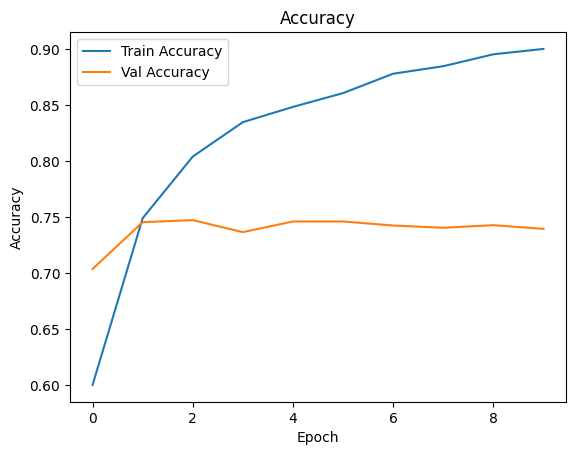

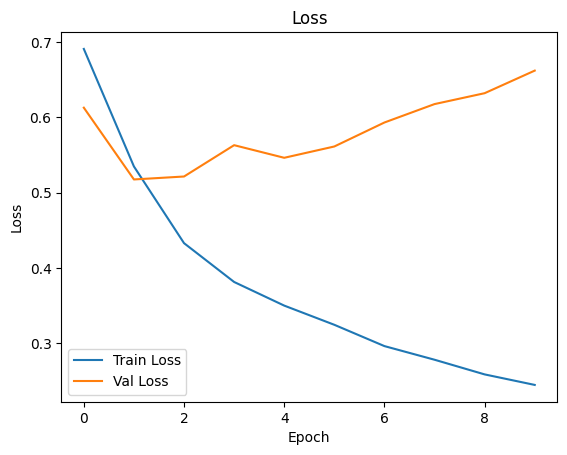

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Train the with CNN

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6626 - loss: 0.5925 - val_accuracy: 0.8456 - val_loss: 0.3535
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8511 - loss: 0.3457 - val_accuracy: 0.8505 - val_loss: 0.3438
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.2826 - val_accuracy: 0.8666 - val_loss: 0.3079
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9029 - loss: 0.2387 - val_accuracy: 0.8554 - val_loss: 0.3324
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9250 - loss: 0.1981 - val_accuracy: 0.8624 - val_loss: 0.3302
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9408 - loss: 0.1573 - val_accuracy: 0.8564 - val_loss: 0.3680
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9577 - loss: 0.1243 - val_accuracy: 0.8511 - val_loss: 0.3805
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9611 - loss: 0.1071 - val_accuracy: 0.

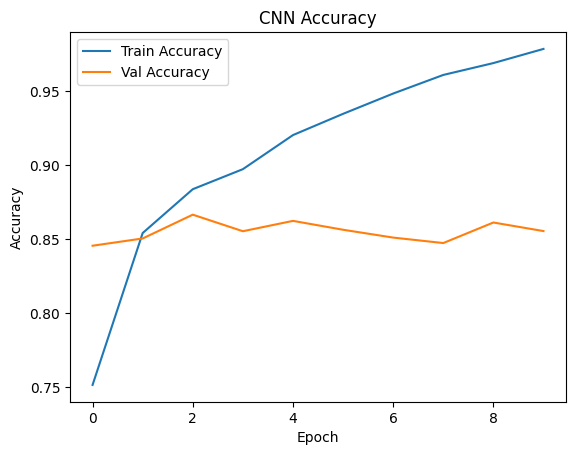

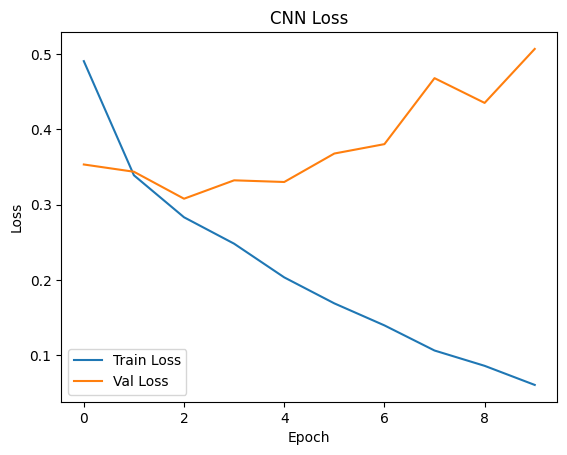

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model_cnn = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False), # Keep embeddings fixed
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Binary classification
])

model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

# Train the model
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=10,
                            batch_size=128,
                            validation_data=(X_test, y_test))

# Evaluate the model
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy_cnn:.2f}")

# Plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Train with LTSM model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6653 - loss: 0.5986 - val_accuracy: 0.7840 - val_loss: 0.4486
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8014 - loss: 0.4312 - val_accuracy: 0.8407 - val_loss: 0.3725
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8499 - loss: 0.3494 - val_accuracy: 0.8495 - val_loss: 0.3476
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8621 - loss: 0.3191 - val_accuracy: 0.8730 - val_loss: 0.2972
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8782 - loss: 0.2901 - val_accuracy: 0.8748 - val_loss: 0.2929
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8863 - loss: 0.2723 - val_accuracy: 0.8819 - val_loss: 0.2784
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8931 - loss: 0.2613 - val_accuracy: 0.8771 - val_loss: 0.2838
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8969 - loss: 0.2478 - val_accu

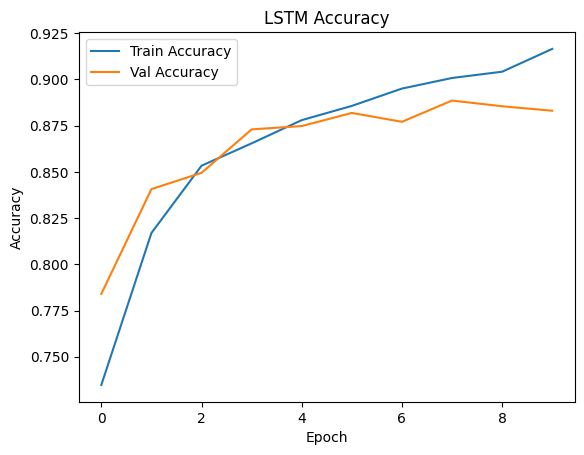

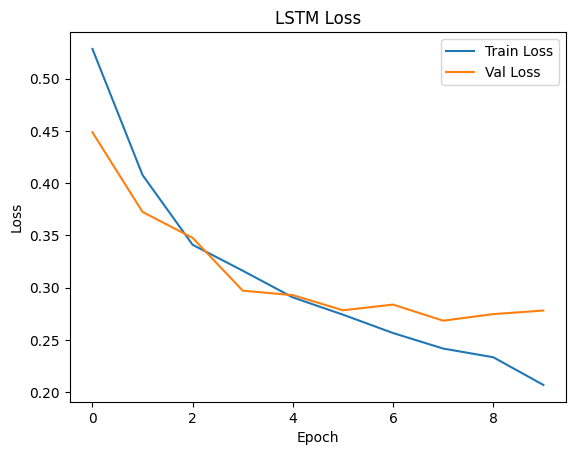

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model_lstm = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False), # Keep embeddings fixed
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Binary classification
])

model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_lstm.summary()

# Train the model
history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=10,
                              batch_size=128,
                              validation_data=(X_test, y_test))

# Evaluate the model
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {accuracy_lstm:.2f}")

# Plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Benchmarking between 3 models

In [20]:
print(f"FCNN Test Accuracy: {accuracy:.2f}")
print(f"CNN Test Accuracy: {accuracy_cnn:.2f}")
print(f"LSTM Test Accuracy: {accuracy_lstm:.2f}")

best_accuracy = max(accuracy, accuracy_cnn, accuracy_lstm)
best_model = ""

if best_accuracy == accuracy:
    best_model = "FCNN"
elif best_accuracy == accuracy_cnn:
    best_model = "CNN"
else:
    best_model = "LSTM"

print(f"\nThe best performing model is: {best_model} with an accuracy of {best_accuracy:.2f}")

FCNN Test Accuracy: 0.74
CNN Test Accuracy: 0.86
LSTM Test Accuracy: 0.88

The best performing model is: LSTM with an accuracy of 0.88
